# Introduction

Accurately predicting survival outcomes for patients undergoing allogeneic hematopoietic cell transplantation (HCT) is a critical challenge in modern healthcare. Existing models often fail to account for disparities related to race, socioeconomic status, and geography, leading to inequitable outcomes.  

This competition focuses on developing machine learning models that predict event-free survival (EFS) in a fair and unbiased manner, particularly across diverse racial groups. The dataset used for this task is synthetic but reflects real-world distributions, enabling participants to develop robust models without compromising patient privacy.  

Our primary evaluation metric is the **Stratified Concordance Index (C-index)**, which measures the predictive performance of models while accounting for fairness among racial categories. The goal is to maximize predictive accuracy while minimizing disparities across groups.  

Key objectives include:  
- **Improving model accuracy** in predicting EFS outcomes.  
- **Ensuring fairness** across racial categories.  
- **Addressing biases** in healthcare predictions to support equitable treatment for all patients.  

This notebook will guide the reader through an end-to-end data science workflow, from **Exploratory Data Analysis (EDA)** to **Model Building and Evaluation**, ensuring transparency, reproducibility, and fairness. 

If you find this notebook helpful, please consider upvoting it. Your support encourages further contributions and improvements. Thank you! 🙏

 **Table of Contents**  

1. **Introduction**   

2. **Exploratory Data Analysis (EDA)**   

3. **Data Preprocessing and Cleaning**  

4. **Model Building**  

5. **Model Evaluation**   

6. **Prediction on test data and Submission**  

In [1]:
!pip download lifelines -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 19.5 MB/s eta 0:00:00
   

In [2]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl -qq
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz -qq
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl -qq
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl -qq
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl -qq

  Preparing metadata (setup.py) ... done


# EDA

This section focuses on performing exploratory data analysis (EDA) on the provided train and test datasets. It involves loading the datasets, examining the distribution of the target variable (`efs`), visualizing the relationship between age and event-free survival time, analyzing the demographic composition through race group distribution, and understanding the age distributions of donors and patients. These steps provide initial insights into the data, helping to identify patterns, trends, and potential areas of interest for further analysis. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [4]:
train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [5]:
train.shape

(28800, 60)

In [6]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [8]:
train.isnull().sum()

ID                            0
dri_score                   154
psych_disturb              2062
cyto_score                 8068
diabetes                   2119
hla_match_c_high           4620
hla_high_res_8             5829
tbi_status                    0
arrhythmia                 2202
hla_low_res_6              3270
graft_type                    0
vent_hist                   259
renal_issue                1915
pulm_severe                2135
prim_disease_hct              0
hla_high_res_6             5284
cmv_status                  634
hla_high_res_10            7163
hla_match_dqb1_high        5199
tce_imm_match             11133
hla_nmdp_6                 4197
hla_match_c_low            2800
rituximab                  2148
hla_match_drb1_low         2643
hla_match_dqb1_low         4194
prod_type                     0
cyto_score_detail         11923
conditioning_intensity     4789
ethnicity                   587
year_hct                      0
obesity                    1760
mrd_hct 

In [9]:
train['efs'].value_counts()

efs
1.0    15532
0.0    13268
Name: count, dtype: int64

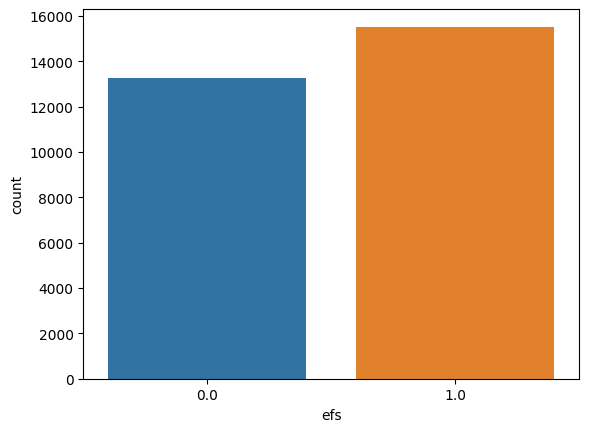

In [10]:
sns.countplot(x='efs', data=train)
plt.show()

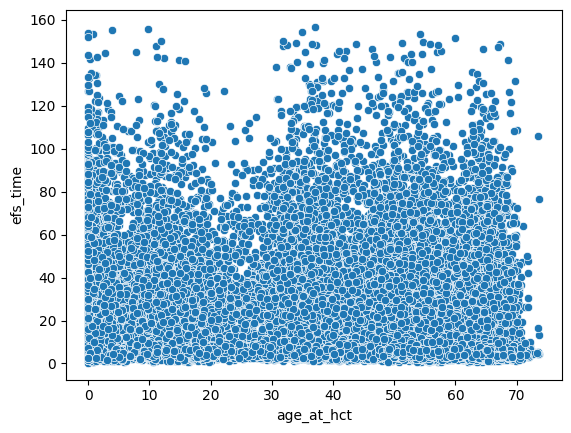

In [11]:
sns.scatterplot(x='age_at_hct', y='efs_time', data=train)
plt.show()

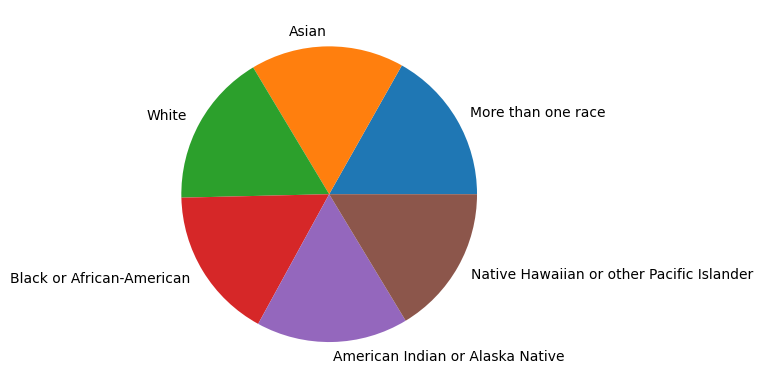

In [12]:
vc= train['race_group'].value_counts()
plt.pie(vc, labels = vc.index)
plt.show()

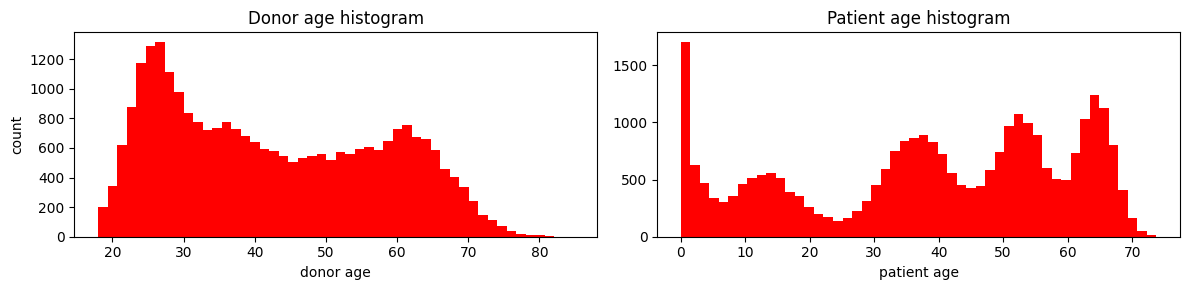

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(train['donor_age'], bins=50, color='red')
plt.title('Donor age histogram')
plt.xlabel('donor age')
plt.ylabel('count')
plt.subplot(1,2,2)
plt.hist(train['age_at_hct'], bins=50, color='red')
plt.title('Patient age histogram')
plt.xlabel('patient age')
plt.tight_layout()
plt.show()

# Data Processing

This section focuses on preparing the data for further analysis and modeling. It includes several steps:
1. **Mapping Disease Groups:** The primary diseases are categorized into broader disease groups for both training and test datasets.
2. **Feature Engineering:** New features such as `ageXcomorbidity` and `hla_match_score` are created to enhance the dataset.
3. **Outlier Removal:** Outliers are identified using z-scores and removed from the training data to improve model performance.
4. **Feature Engineering Function:** A function is defined to categorize age groups, calculate BMI, and apply other transformations.
5. **Data Cleaning Functions:** Functions are created to clean and categorize specific columns like `melphalan_dose`, `cmv_status`, and `dri_score`.
6. **Feature Transformation:** Additional features are extracted and categorized from existing columns, such as treatment status and radiation dosage.
7. **Handling Missing Values:** Numerical columns are filled with the median, and categorical columns with 'Unknown'.
8. **Label Encoding:** Categorical variables are encoded to numerical values for compatibility with machine learning algorithms.

These steps ensure the dataset is clean, consistent, and enriched with meaningful features, setting the stage for effective model training and analysis.


In [14]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore

In [15]:
train['prim_disease_hct'].value_counts()

prim_disease_hct
ALL                     8102
AML                     7135
MDS                     3046
IPA                     1719
MPN                     1656
IEA                     1449
NHL                     1319
IIS                     1024
PCD                      869
SAA                      713
AI                       449
HIS                      445
Other leukemia           366
Solid tumor              207
IMD                      144
Other acute leukemia      83
HD                        54
CML                       20
Name: count, dtype: int64

In [16]:
train['prim_disease_group'] = train['prim_disease_hct'].map({
    'ALL': 'Leukemia',
    'AML': 'Leukemia',
    'MDS': 'Leukemia',
    'Other acute leukemia': 'Leukemia',
    'Other leukemia': 'Leukemia',
    'CML': 'Leukemia',

    'NHL': 'Lymphoma',
    'HD': 'Lymphoma',

    'Solid tumor': 'Solid Tumor',

    'IPA': 'MPN',
    'IEA': 'MPN',

    'SAA': 'Autoimmune and Other Diseases',
    'AI': 'Autoimmune and Other Diseases',
    'HIS': 'Autoimmune and Other Diseases',
    'PCD': 'Autoimmune and Other Diseases',
    'IIS': 'Autoimmune and Other Diseases',
    'IMD': 'Autoimmune and Other Diseases'
}).fillna('Other')

test['prim_disease_group'] = test['prim_disease_hct'].map({
    'ALL': 'Leukemia',
    'AML': 'Leukemia',
    'MDS': 'Leukemia',
    'Other acute leukemia': 'Leukemia',
    'Other leukemia': 'Leukemia',
    'CML': 'Leukemia',

    'NHL': 'Lymphoma',
    'HD': 'Lymphoma',

    'Solid tumor': 'Solid Tumor',

    'IPA': 'MPN',
    'IEA': 'MPN',

    'SAA': 'Autoimmune and Other Diseases',
    'AI': 'Autoimmune and Other Diseases',
    'HIS': 'Autoimmune and Other Diseases',
    'PCD': 'Autoimmune and Other Diseases',
    'IIS': 'Autoimmune and Other Diseases',
    'IMD': 'Autoimmune and Other Diseases'
}).fillna('Other')

In [17]:
train['ageXcomorbidity'] = train['age_at_hct'] * train['comorbidity_score']
train['hla_match_score'] = (train['hla_match_a_high'] + train['hla_match_b_high'] + train['hla_match_c_high'])/3

test['ageXcomorbidity'] = test['age_at_hct'] * test['comorbidity_score']
test['hla_match_score'] = (test['hla_match_a_high'] + test['hla_match_b_high'] + test['hla_match_c_high'])/3

In [18]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,prim_disease_group,ageXcomorbidity,hla_match_score
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356,MPN,0.000,NaN
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672,Leukemia,131.115,2.0
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793,Autoimmune and Other Diseases,0.000,2.0
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349,Leukemia,0.000,2.0
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223,Other,29.740,2.0


In [19]:
numerical_cols = train.select_dtypes(include=[np.number]).columns
zscores = np.abs(zscore(train[numerical_cols]))
outliers_zscore = (zscores>3)
train = train[~outliers_zscore.any(axis=1)]

In [20]:
train.shape

(28286, 63)

In [21]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    bins = [0, 18, 40, 60, 100]
    labels = ['Child', 'Adult', 'Senior', 'Elderly']
    data['age_group'] = pd.cut(data['age_at_hct'], bins=bins, labels=labels)

    if 'height' in data.columns and 'weight' in data.columns:
        data['BMI'] = data['weight'] / (data['height'] / 100) **2

    return data

In [22]:
def clean_melphalan_dose(dose):
    
    if pd.isna(dose):
        return 'Unknown'

    if 'Mel not given' in dose or 'N/A' in dose:
        return 'Not Given'
    elif 'MEL' in dose:
        return 'Given'
    else:
        return 'Unknown'

In [23]:
cmv_status_map = {
    '+/+': 'Active CMV Infection',
    '-/+': 'Acute CMV Infection',
    '-/-': 'No CMV Exposure',
    '+/-': 'Past CMV Infection'
}

In [24]:
def clean_dri_score(score):

    if pd.isna(score):
        return 'Missing'

    if score == 'Low':
        return 'Low'
    elif score == 'Intermediate':
        return 'Intermediate'
    elif score == 'High':
        return 'High'
    elif score == 'Very high':
        return 'Very High'
    elif 'N/A - pediatric' in score:
        return 'Unclassified'
    elif 'TBD cytogenetics' in score:
        return 'Unclassified'
    elif 'Missing disease status' in score:
        return 'Missing'
    elif 'N/A - disease not classifiable' in score:
        return 'Unclassified'
    elif 'TED AML' in score or 'missing cytogenetics' in score:
        return 'Unclassified'
    else:
        return 'Unknown'

In [25]:
def extract_tbi(row):
    return 'Yes' if 'TBI' in row else 'No'

def extract_chemotherapy(row):
    return 'Yes' if 'Cy' in row else 'No'

def extract_other_conditions(row):
    return 'Yes' if 'Other' in row else 'No'

In [26]:
def extract_radiation_dose(row):
    if '<= cGy' in row:
        return '<= cGy'
    elif '> cGy' in row:
        return '> cGy'
    elif '-cGy' in row:
        return '-cGy'
    elif 'unknown dose' in row:
        return 'Unknown Dose'
    return 'No Radiation'

In [27]:
def extract_radiation_dose_quantity(row):
    if '<= cGy' in row or '> cGy' in row:
        return 'Specific Dose Mentioned'
    return 'Missing'

In [28]:
def extract_treatment_status(row):
    if 'No TBI' in row:
        return 'No Radiation or Chemotherapy'
    elif 'Cy' in row and 'TBI' in row:
        return 'TBI + Chemotherapy'
    elif 'Cy' in row:
        return 'Chemotherapy Only'
    elif 'TBI' in row:
        return 'TBI Only'
    return 'Unknown'

In [29]:
def extract_dose_methodology(row):
    if 'single' in row:
        return 'Single Dose'
    elif 'fractionated' in row:
        return 'Fractionated Dose'
    elif '-cGy' in row:
        return 'No Radiation'
    return 'Unknown Dose Method'

In [30]:
train = feature_engineering(train)
train['melphalan_dose'] = train['melphalan_dose'].apply(clean_melphalan_dose)
train['cmv_status'] = train['cmv_status'].map(cmv_status_map)
train['dri_score'] = train['dri_score'].apply(clean_dri_score)
train['TBI_status'] = train['tbi_status'].apply(extract_tbi)
train['Chemotherapy_status'] = train['tbi_status'].apply(extract_chemotherapy)
train['Other_Conditions_status'] = train['tbi_status'].apply(extract_other_conditions)
train['Radiation_Dosage'] = train['tbi_status'].apply(extract_radiation_dose)
train['Radiation_Dosage_Quantity'] = train['tbi_status'].apply(extract_radiation_dose_quantity)
train['Treatment_Status'] = train['tbi_status'].apply(extract_treatment_status)
train['Dose_Methodology'] = train['tbi_status'].apply(extract_other_conditions)


test = feature_engineering(test)
test['melphalan_dose'] = test['melphalan_dose'].apply(clean_melphalan_dose)
test['cmv_status'] = test['cmv_status'].map(cmv_status_map)
test['dri_score'] = test['dri_score'].apply(clean_dri_score)
test['TBI_status'] = test['tbi_status'].apply(extract_tbi)
test['Chemotherapy_status'] = test['tbi_status'].apply(extract_chemotherapy)
test['Other_Conditions_status'] = test['tbi_status'].apply(extract_other_conditions)
test['Radiation_Dosage'] = test['tbi_status'].apply(extract_radiation_dose)
test['Radiation_Dosage_Quantity'] = test['tbi_status'].apply(extract_radiation_dose_quantity)
test['Treatment_Status'] = test['tbi_status'].apply(extract_treatment_status)
test['Dose_Methodology'] = test['tbi_status'].apply(extract_other_conditions)

In [31]:
train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,prim_disease_group,ageXcomorbidity,hla_match_score,age_group,TBI_status,Chemotherapy_status,Other_Conditions_status,Radiation_Dosage,Radiation_Dosage_Quantity,Treatment_Status,Dose_Methodology
0,0,Unknown,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,Active CMV Infection,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,Not Given,8.0,No,2.0,No,10.0,0.0,42.356,MPN,0.000,NaN,Child,Yes,No,No,No Radiation,Missing,No Radiation or Chemotherapy,No
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,Active CMV Infection,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.290,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,Not Given,8.0,No,2.0,Yes,10.0,1.0,4.672,Leukemia,131.115,2.000000,Senior,Yes,No,Yes,No Radiation,Missing,TBI Only,Yes
2,2,Unknown,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,Active CMV Infection,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,Not Given,8.0,No,2.0,No,10.0,0.0,19.793,Autoimmune and Other Diseases,0.000,2.000000,Adult,Yes,No,No,No Radiation,Missing,No Radiation or Chemotherapy,No
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,Active CMV Infection,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.810,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,Given,8.0,No,2.0,No,10.0,0.0,16.223,Other,29.740,2.000000,Adult,Yes,No,No,No Radiation,Missing,No Radiation or Chemotherapy,No
5,5,High,No,Poor,Yes,2.0,7.0,TBI + Cy +- Other,No,4.0,Peripheral blood,No,No,No,ALL,5.0,Active CMV Infection,8.0,1.0,P/P,6.0,1.0,No,1.0,1.0,PB,TBD,MAC,Hispanic or Latino,2015,Yes,NaN,No,NaN,2.0,No,27.274,No,1.0,No,32.143,2.0,Cyclophosphamide alone,No,F-F,1.0,White,2.0,90.0,No,Permissive mismatched,Related,Not Given,5.0,No,2.0,Yes,6.0,1.0,7.095,Leukemia,64.286,1.666667,Adult,Yes,Yes,Yes,No Radiation,Missing,TBI + Chemotherapy,Yes


In [32]:
numeric_columns = train.select_dtypes(include=['number'])

for col in numeric_columns:
    train[col] = train[col].fillna(train[col].median())

train[train.select_dtypes(include=['object']).columns] = train.select_dtypes(include=['object']).fillna('Unknown')

In [33]:
numeric_columns = test.select_dtypes(include=['number'])

for col in numeric_columns:
    test[col] = test[col].fillna(test[col].median())

test[test.select_dtypes(include=['object']).columns] = test.select_dtypes(include=['object']).fillna('Unknown')

In [34]:
categorical_columns = train.select_dtypes(include=['object', 'category'])

le = LabelEncoder()

for col in categorical_columns:
    train[col] = le.fit_transform(train[col].astype(str))

In [35]:
categorical_columns = test.select_dtypes(include=['object', 'category'])

le = LabelEncoder()

for col in categorical_columns:
    test[col] = le.fit_transform(test[col].astype(str))

In [36]:
train.isnull().sum().sort_values()

pulm_moderate                0
hla_low_res_10               0
efs                          0
efs_time                     0
prim_disease_group           0
                            ..
Radiation_Dosage             0
Radiation_Dosage_Quantity    0
Treatment_Status             0
Dose_Methodology             0
ID                           0
Length: 71, dtype: int64

# Model Building and Testing

This section involves constructing and evaluating machine learning models using the training dataset. The steps include:
1. **Feature Selection:** A set of features is selected from the dataset for training the models.
2. **Data Splitting:** The dataset is split into training and validation sets to evaluate the model's performance.
3. **Data Scaling:** Features are standardized using `StandardScaler` to ensure that all variables contribute equally to the model.
4. **Model Training (Decision Tree):** A Decision Tree Regressor is trained on the training data, and its performance is evaluated using Root Mean Squared Error (RMSE).
5. **Model Training (Random Forest):** A Random Forest Regressor is also trained, and its performance is similarly evaluated using RMSE.
6. **Cross-Validation:** Cross-validation is performed on the Random Forest model to ensure robust performance.
7. **C-index Calculation:** The concordance index is calculated for the validation set to evaluate the model's predictive accuracy for survival analysis.

These steps help in building, validating, and comparing different models to identify the best performing one for predicting the outcomes.

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from lifelines.utils import concordance_index

In [38]:
features = ['ID', 'dri_score', 'psych_disturb', 'cyto_score', 'diabetes',
       'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia',
       'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue',
       'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status',
       'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6',
       'hla_match_c_low', 'rituximab', 'hla_match_drb1_low',
       'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail',
       'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct',
       'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe',
       'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer',
       'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue',
       'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score',
       'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related',
       'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high',
       'pulm_moderate', 'hla_low_res_10','prim_disease_group', 'ageXcomorbidity', 
        'hla_match_score', 'age_group', 'TBI_status', 'Chemotherapy_status', 
        'Other_Conditions_status', 'Radiation_Dosage', 'Radiation_Dosage_Quantity',
        'Treatment_Status', 'Dose_Methodology']

In [39]:
X = train[features]
y = train[['efs', 'efs_time']]

In [40]:
print(X.shape, y.shape)

(28286, 69) (28286, 2)


In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [43]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train['efs'])

y_pred_dt = dt_model.predict(X_val)
dt_rmse = mean_squared_error(y_val['efs'], y_pred_dt)

print(f"Decision_Tree RMSE: {dt_rmse:.4f}")

Decision_Tree RMSE: 0.4116


In [44]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train['efs'])

y_pred_rf = rf_model.predict(X_val)
rf_rmse = mean_squared_error(y_val['efs'], y_pred_rf)

print(f"Random Forest RMSE: {rf_rmse:.4f}")

Random Forest RMSE: 0.2127


In [45]:
# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error')
# grid_search_rf.fit(X_train, y_train)

In [46]:
# best_params = grid_search_rf.best_params_
# print("Best Performance: ", best_params)

# best_score = grid_search_rf.best_score_
# print("Best Score: ", best_score)

# best_model = grid_search_rf.best_estimatpr_
# print("Best Model: ", best_model)

In [47]:
scores = cross_val_score(rf_model, X_train, y_train['efs'], cv=5, scoring='neg_mean_squared_error')

print("Cross-validation MSE: ", -scores.mean())

Cross-validation MSE:  0.2083425948716196


In [48]:
c_index = concordance_index(y_val['efs_time'], y_pred_rf, event_observed=y_val['efs'])
print("C-index on validation set: ", c_index)

C-index on validation set:  0.3689960711177226


# Prediction on Test Data

In [49]:
test_features = test[features]
test_prediction = rf_model.predict(test_features)

# Prepare Submission File

In [50]:
submissions = pd.DataFrame({
    'ID': test['ID'],
    'prediction': test_prediction
})

submissions.to_csv('submission.csv', index=False)